In [59]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
!pip install python-dotenv

In [61]:
!pip install git+git://github.com/linalgo/linalgo-sdk.git requests pillow

  Cloning git://github.com/linalgo/linalgo-sdk.git to /private/var/folders/y_/z7rsj30x4z10qrwzkcwpgnrw0000gn/T/pip-req-build-o4uwv2_a
  Running command git clone -q git://github.com/linalgo/linalgo-sdk.git /private/var/folders/y_/z7rsj30x4z10qrwzkcwpgnrw0000gn/T/pip-req-build-o4uwv2_a


In [62]:
import io
from io import BytesIO
import os

from typing import Dict, List

from google.cloud import vision

from PIL import Image
import requests

#from linimage.extractor import Extractor
from linalgo.annotate.models import Document, Annotation, Entity, Target, Annotator
from linalgo.annotate.bbox import BoundingBox
from linalgo.annotate import b_entity, p_entity, s_entity, w_entity
from linalgo.hub.client import LinalgoClient

In [63]:
token = os.getenv('LINHUB_TOKEN')
print(token)

None


In [101]:
token = "615caa329be0d2e1d529a7f0b368cb3b43b62745"
client = LinalgoClient(token=token, api_url='https://linhub.api.linalgo.com/v1')
task = client.get_task('a9b4a03b-3af5-476f-8656-c69a32ea9866', verbose=True)

Retrivieving task with id a9b4a03b-3af5-476f-8656-c69a32ea9866...
Retrieving annotators... (9 found)
Retrieving entities... (8 found)
Retrieving documents... (348 found)
Retrieving annotations... (35049 found)


In [102]:
def add_ocr_annotations(doc: Document, ocr_annotations) -> List[Dict]:
    """
    Extract bounding boxes using Google Vision API

    :param doc: Document to annotate
    :param response: Google Vision API full_text response
    :return:
    """
    annotator = Annotator(name='google-ocr')
    for page in ocr_annotations.pages:
        for block in page.blocks:
            for paragraph in block.paragraphs:
                for word in paragraph.words:
                    text = ''
                    for s in word.symbols:
                        text += s.text
                        v = s.bounding_box.vertices
                        t = Target(selectors=[BoundingBox.fromVertices(v)])
                        Annotation(entity=s_entity, document=doc,
                                   body=s.text, target=t, annotator=annotator)
                    v = word.bounding_box.vertices
                    t = Target(selectors=[BoundingBox.fromVertices(v)])
                    Annotation(entity=w_entity, document=doc,
                               body=text, target=t, annotator=annotator)
                v = paragraph.bounding_box.vertices
                t = Target(selectors=[BoundingBox.fromVertices(v)])
                Annotation(entity=p_entity, document=doc, body='', target=t,
                           annotator=annotator)
            v = block.bounding_box.vertices
            t = Target(selectors=[BoundingBox.fromVertices(v)])
            Annotation(entity=b_entity, document=doc, body='', target=t,
                       annotator=annotator)
    return doc


os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/tomohiro/code/zapjanice/textbook_project/notebooks/le-wagon.json'


def ocr(doc: Document):

    response = requests.get(doc.content)
    img = BytesIO(response.content)
    client = vision.ImageAnnotatorClient()
    image = vision.Image(content=img.read())
    response = client.text_detection(image=image)
    return add_ocr_annotations(doc, response.full_text_annotation)

In [103]:
doc = task.documents[0]
ocr_doc = ocr(doc)

In [85]:
set(a.entity.name for a in doc.annotations)

{'BLOCK',
 None,
 'PARAGRAPH',
 'SYMBOL',
 'WORD',
 'furi',
 'item',
 'sent-en',
 'sent-jp',
 'sent-zh',
 'word-en',
 'word-jp',
 'word-zh'}

In [86]:
a1 = doc.annotations[0]
b1 = a1.target.selectors[0]
a2 = doc.annotations[100]
b2 = a2.target.selectors[0]
print(a1, b1)
print(a2, b2)

Annotation::furi {(635.9047476161111, 706.2292889351759), (654.405345530628, 706.2292889351759), (654.405345530628, 722.0869442904761), (635.9047476161111, 722.0869442904761)}
Annotation::5401b95f-0b7c-43d1-a0ad-bc793f0a8bb5 {(568.4380564525135, 148.84456005370998), (621.6517815029732, 148.84456005370998), (621.6517815029732, 167.46936382137088), (568.4380564525135, 167.46936382137088)}


In [87]:
b1.intersects(b2)

False

In [88]:
b1.overlap(b2)

0.0

In [89]:
b3 = b1.intersection(b2)
b3

{(0, 0), (0, 0), (0, 0), (0, 0)}

In [90]:
task.annotators

[Annotator::janice,
 Annotator::lynne74,
 Annotator::andrewlee,
 Annotator::B.rowen,
 Annotator::xufei,
 Annotator::arnaud,
 Annotator::rheamae,
 Annotator::wallie,
 Annotator::Patrick]

In [93]:
para_a = []
for annotation in doc.annotations:
    if annotation.entity.name == 'PARAGRAPH':
        para_a.append(annotation)

In [98]:
paragraph_annotations = [annotation for annotation in doc.annotations if annotation.entity.name=="PARAGRAPH"]

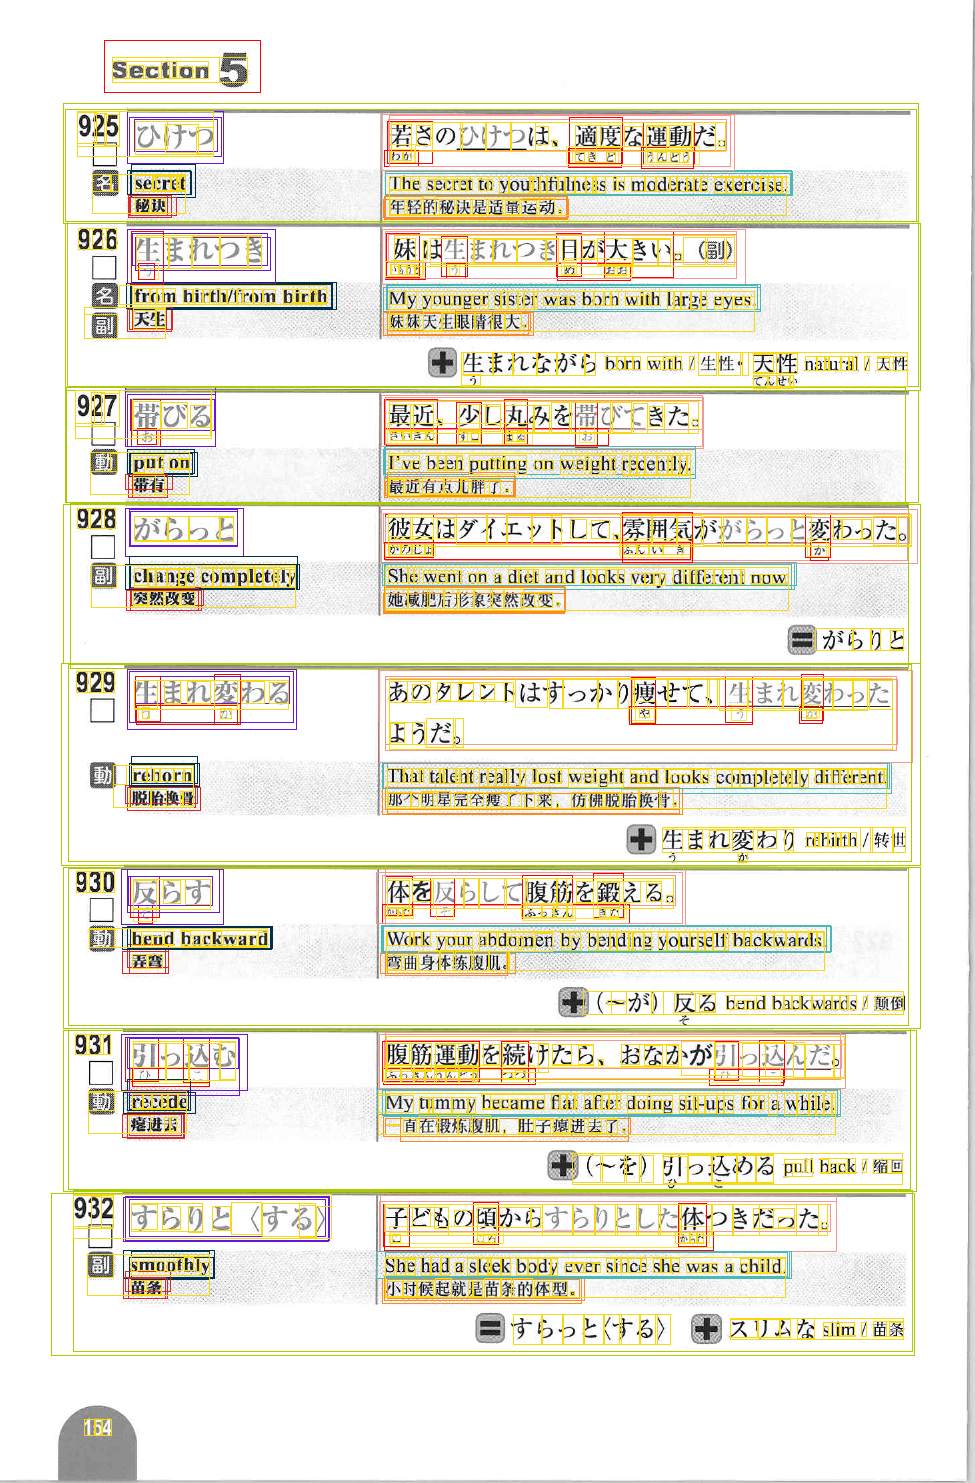

In [99]:
draw_bounding_boxes(img, paragraph_annotations)

In [104]:
response = requests.get(doc.content)
img = BytesIO(response.content)

In [115]:
!pip install opencv-python

In [116]:
import cv2

In [117]:
image = vision.Image(content=img.read())
cv2.imread(image)

TypeError: Can't convert object of type 'Image' to 'str' for 'filename'

TypeError: Image data of dtype object cannot be converted to float

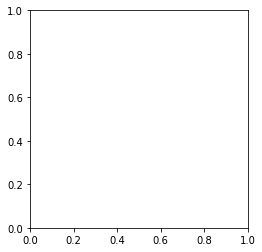

In [111]:
import matplotlib.pyplot as plt
plt.imshow(image)